In [3]:
import torch, torchvision
from torch import nn
import PIL.Image, os, scipy.io
import matplotlib.pyplot as plt

In [4]:
import torch.utils.data

class FlowerDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_directory, labels_file):
        super(FlowerDataset, self).__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.dataset_images = []

        self.basic_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.ToTensor()
        ])

        self.class_names = [
            "pink primrose", "hard-leaved pocket orchid", "bolero deep blue", "sweet pea", "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"
        ]

        self.labels_mat = scipy.io.loadmat(labels_file)
        self.dataset_labels = torch.from_numpy(
            self.labels_mat["labels"][0]
        ).type(torch.int16).to(self.device) - 1
        
        for path in sorted(os.listdir(dataset_directory)):
            pil_image = PIL.Image.open(f"{dataset_directory}/{path}") 
            self.dataset_images.append(
                self.basic_transform(
                    pil_image
                ).to(self.device)
            )
            pil_image.close()

    def __getitem__(self, index):
        return [self.dataset_images[index], self.dataset_labels[index]]

    def __len__(self):
        return len(self.dataset_images)

In [5]:
dataset = FlowerDataset(
    dataset_directory="./flower_images",
    labels_file="./imagelabels.mat"
)

In [97]:
dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=256,
    shuffle=True
)

(-0.5, 223.5, 223.5, -0.5)

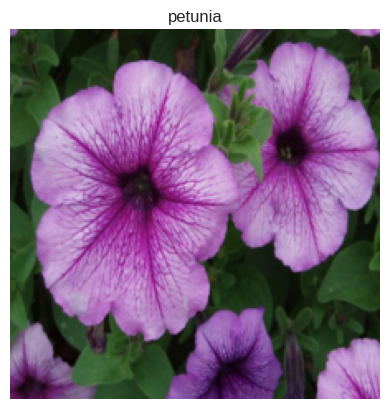

In [47]:
sample_batch_data, sample_batch_label = next(iter(dataloader))

plt.title(dataset.class_names[sample_batch_label[0].item()])
plt.imshow(sample_batch_data[0].permute(1, 2, 0))
plt.axis(False)

In [141]:
class FlowerVisionModelV0(nn.Module):
    def __init__(self, in_channels, hidden_units, out_shape):
        super(FlowerVisionModelV0, self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*20*20, out_features=out_shape),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        return self.classifier.forward(
            self.conv_block_2.forward(
                self.conv_block_1.forward(X)
            )
        )

class FlowerVisionModelV1(nn.Module):
    def __init__(self, in_channels, hidden_units, out_shape):
        super(FlowerVisionModelV1, self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*169, out_features=out_shape),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        return self.classifier.forward(
            self.conv_block_2.forward(
                self.conv_block_1.forward(X)
            )
        )
    
class FlowerVisionModelV2(nn.Module):
    def __init__(self, in_channels, hidden_units, out_shape):
        super(FlowerVisionModelV2, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=out_shape),
            nn.Softmax()
        )

    def forward(self, X):
        return self.classifier.forward(
            self.conv_block_2.forward(
                self.conv_block_1.forward(X)
            )
        )
    
class ResNet50Mod(nn.Module):
    def __init__(self, in_channels, hidden_units, out_shape):
        super(ResNet50Mod, self).__init__()

        self.stage_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=7, stride=2),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.stage_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=2)
        )

        self.stage_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=2),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=2),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*1, out_features=out_shape),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        return self.classifier.forward(
            self.stage_3.forward(
                self.stage_2.forward(
                    self.stage_1.forward(
                        X
                    )
                )
            )
        )

In [131]:
model = ResNet50Mod(
    in_channels=3,
    hidden_units=10,
    out_shape=len(dataset.class_names)
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
epochs = 100

In [50]:
loss_history = []

In [ ]:
for epoch in range(epochs):
    total_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        y_logits = model.forward(X)
        loss = criterion(y_logits, y.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loss_history.append(loss.item())

        print(f"Batch: {batch+1} | Loss: {loss.item():.4f}", end="\r")

    print(f"Epoch: {epoch+1} | Avg loss: {total_loss/(batch+1):.4f}")

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")
plt.figure(figsize=(20, 4))
plt.title("Loss over iterations")
plt.plot(range(len(loss_history)), loss_history, label="Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.show()

In [223]:
model = torch.load("./flowers-model-v1-3.pth", map_location=torch.device("cpu"))

In [224]:
y_true = []
y_pred = []

model.eval()
with torch.inference_mode():
    for X, y in dataloader:
        y_true += y.tolist()
        y_pred += model.forward(X).argmax(1).tolist()
        print(f"Length of predictions: {len(y_pred)}/{len(dataloader)*256}", end="\r")

In [225]:
from torchmetrics import Accuracy

accuracy_fn = Accuracy(task="multiclass", num_classes=102)
acc = accuracy_fn(torch.Tensor(y_pred), torch.Tensor(y_true))

print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 90.29%


In [232]:
!wget "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRh0omdyS5kEiIzAmiksKefaTMbb50Iq1cKFw&s" -O flower.jpg

--2024-07-12 12:15:35--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRh0omdyS5kEiIzAmiksKefaTMbb50Iq1cKFw&s
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.17.110, 2a00:1450:4017:810::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.17.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11330 (11K) [image/jpeg]
Saving to: ‘flower.jpg’

flower.jpg          100%[===================>]  11.06K  --.-KB/s    in 0.01s   

2024-07-12 12:15:36 (964 KB/s) - ‘flower.jpg’ saved [11330/11330]



('sunflower',
 tensor([1.6360e-08, 4.8275e-08, 1.6374e-12, 8.6037e-07, 1.4295e-08, 7.6703e-06,
         7.7224e-10, 1.3379e-06, 2.4381e-09, 1.2703e-17, 8.9341e-07, 5.8199e-12,
         1.0154e-10, 7.8666e-13, 2.9971e-18, 1.5665e-13, 6.0195e-04, 3.0387e-04,
         3.7958e-11, 4.4889e-16, 5.0311e-16, 1.1812e-16, 1.8262e-12, 1.6397e-17,
         5.7465e-08, 6.5863e-08, 1.2254e-13, 3.6498e-09, 1.7541e-15, 1.3365e-12,
         4.4297e-10, 2.0130e-09, 2.4332e-09, 1.2567e-15, 3.5237e-18, 1.9118e-14,
         1.1021e-09, 2.1468e-09, 3.7042e-15, 1.7375e-03, 8.6396e-09, 5.0001e-12,
         5.2478e-07, 2.2575e-11, 1.3842e-12, 2.1865e-18, 2.7222e-16, 4.3050e-16,
         1.2835e-13, 2.4829e-13, 3.3715e-12, 7.4385e-14, 1.8330e-09, 1.8082e-01,
         7.2897e-12, 1.2803e-16, 1.3819e-12, 3.0474e-14, 1.4653e-16, 6.1955e-13,
         1.6544e-10, 1.2608e-05, 2.3327e-14, 3.5172e-17, 1.3114e-17, 3.1231e-17,
         1.3864e-14, 2.2063e-11, 1.2797e-12, 2.1653e-11, 1.9806e-07, 1.6722e-05,
         2.247

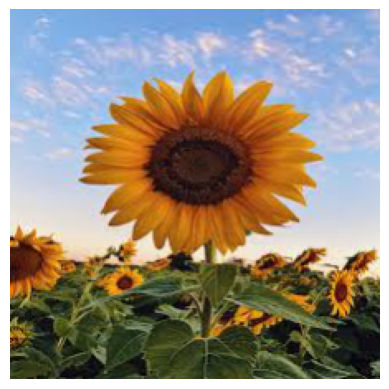

In [233]:
from random import choice

flower = dataset.basic_transform(
    # PIL.Image.open("./flower_images/" + choice(os.listdir("./flower_images/")))
    PIL.Image.open("./flower.jpg")
)

plt.imshow(flower.permute(1, 2, 0))
plt.axis(False)

model.eval()
with torch.inference_mode():
    y_logits = model.forward(flower.unsqueeze(0)).squeeze()

dataset.class_names[y_logits.argmax()], y_logits, y_logits[y_logits.argmax()], y_logits.argmax()